<div style="background-color: beige; padding: 10px;">
<p style='font-size: 22px; text-align: right;'><strong>Stephanie Dragoi and Victor Matsumoto</strong></p>
<p style='font-size: 22px; text-align: right;'><strong>DUE 20231026</strong></p>
<p style='font-size: 22px; text-align: right;'><strong>MLR Project- Used Car Pricing Model</strong></p>
</div>

# Introduction and Car Selection

# Munging and Field Engineering

The torque column had conflicting units; most observations were entered in Nm@rpm, but a few were entered in kgm@rpm, which we changed to Nm@rpm. Some of the torques were given in the format torque@[range of rpms], which we changed to torque@lower_rpm. <br>
<br>
For the engine, max_power, and torque fields, we changed all the values to be expressed to the one's place (ex. 65.01 became 65). <br>
<br>
<br>
One of the models was listed as Tata Indigo VS, which is not a valid model, so we dropped this observation, being unable to match its specifications to the Indigo CS, which was one model to which 'VS' could have plausibly been referring. Three additional Tata Indigo observations were dropped because their model was listed simply as "TDI," which could refer to the quite different Tata Indigo LX (TDI): 2008 - 2011, Tata Indigo LX (TDI) BS-III: 2008 - 2011, Tata Indigo CS LE (TDI) BS-III: 2008 - 2011, or Tata Indigo CS LS (TDI) BS-III: 2008 - 2011. <br>
<br>
Since the engine, max_power, and torque fields give very similar information, they were combined into one field called engine_max_power_torque, with data in this field being in the format "engine max_power torque@x_rpm". However, ultimately, our engineered field showed that choosing engine, max_power, or torque for calculations would be sufficient rather than attempting to use all three, since they essentially measure the same thing.<br>
<br>
Since many of the model names were extremely specific, two fields were created to replace the original model_contd field: one called model_gen, with the general name of the model, such as "CS" for "CS eGLS BS IV," and one with the original, ultra-specific model name, adjusted in a 2-3 cases to omit information like trim. <br>
<br>
Three fields were dropped since all the observations had the same value: make, transmission, and seats. <br>
<br>
<br>
EXPLAIN WHY TRIM FIELD WAS NOT ADDED !!!!!!!!!!!!!!

# Step 4: Import Libraries

In [140]:
# Import all necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip

# Step 5: Python Functions

In [141]:
# Define useful functions including regression_performance, calculate_vif

def regression_performance(model, X, y):
 yhat = model.predict(X)
 mse = mean_squared_error(y, yhat)
 mae = mean_absolute_error(y, yhat)
 mape = np.mean(np.abs(y - yhat) / y) * 100 # mean absolute pct. error
 df_performance_summary = pd.DataFrame(
 {"MSE": mse, "MAE": mae, "MAPE": mape}, index=[0])
 return df_performance_summary

# Function to return a dataframe showing the VIF for each explanatory variable:
# Note that the explanatory variables are in a dataframe called Xdataframe.
def calculate_vif(Xdataframe):
 temp_df = pd.DataFrame()
 temp_df["column name"] = Xdataframe.columns
 temp_df["VIF"] = [variance_inflation_factor(Xdataframe.values, k)
 for k in range(len(Xdataframe.columns))]
 return temp_df

# Step 6: Dataframe Summary Statistics

In [142]:
# read csv and describe
df = pd.read_csv('Munged and Engineered Car data.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,284.0,2010.904930,2.944980,2003.000000,2009.00000,2011.00000,2013.00000,2018.0000
asking_price,284.0,8935.902465,4133.273001,2000.000000,5699.96250,8500.00000,11424.95000,22500.0000
miles_driven,284.0,59907.544600,27672.469662,7454.545455,42708.33333,55909.09091,74545.45455,168348.4848
num_previous_owners,284.0,1.665493,0.735812,1.000000,1.00000,2.00000,2.00000,4.0000


# Step 7: Variable Types and Missing Data

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   model                    284 non-null    object 
 1   model_gen                284 non-null    object 
 2   model_spec               284 non-null    object 
 3   year                     284 non-null    int64  
 4   asking_price             284 non-null    float64
 5   miles_driven             284 non-null    float64
 6   fuel                     284 non-null    object 
 7   seller_type              284 non-null    object 
 8   num_previous_owners      284 non-null    int64  
 9   mileage                  284 non-null    object 
 10  engine                   284 non-null    object 
 11  max_power                284 non-null    object 
 12  torque                   284 non-null    object 
 13  engine_max_power_torque  284 non-null    object 
dtypes: float64(2), int64(2), o

Most fields are of type object, with a few being int64 or float64. There is no missing data, since all of it has been handled using imputation (see step 8).

# Step 8: Missing Data Treatment

Missing data was treated in the spreadsheet using imputation. 5 observations of make/model Tata Indica DLS, 1 observation of make/model Tata Indica DLX, 5 observations of make/model Tata Indica Vista Aqua 1.3 Quadrajet (ABS), and 2 observations of make/model Tata Indica Vista Quadrajet LS were missing values for the following fields: <br>
* mileage
* engine
* max_power
* torque
* seats
<br>
<br>
The missing values were imputed using information from the websites CarFolio and CarWale, which provided information for the above fields based on make and model.

# Step 9: Categorical Conversion

In [144]:
# Convert all variables that are logically categorical, except for model year, into true categories
# Code from official Pandas documentation on categorical data

categorical_columns = ['model', 'model_gen', 'model_spec','fuel','seller_type','num_previous_owners','mileage','engine','max_power','torque']
df[categorical_columns] = df[categorical_columns].astype('category')

# Step 10: Explanatory/Target Split

In [145]:
# split data into explanatory matrix (X) and target column (y)

X = df.drop(['asking_price'], axis = 1)
y = df['asking_price']

# Step 11: Dummy Variables for Categorical Values

In [146]:
# Perform one-hot encoding for all categorical values

X = X.drop(['max_power', 'torque', 'engine_max_power_torque'], axis = 1)
print(X.columns)
# Perform one-hot encoding for all categorical values
X_encoded = pd.get_dummies(
    X,
    columns=X.select_dtypes(include=["object","category"]).columns.tolist(),
    drop_first=True
)
X_encoded = X_encoded.drop(['year','miles_driven'], axis = 1)

# Combine the original columns and one-hot encoding columns
X = pd.concat([X, X_encoded], axis=1)
X

Index(['model', 'model_gen', 'model_spec', 'year', 'miles_driven', 'fuel',
       'seller_type', 'num_previous_owners', 'mileage', 'engine'],
      dtype='object')


,model,model_gen,model_spec,year,miles_driven,fuel,seller_type,num_previous_owners,mileage,engine,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
0,Indigo,eCS,CR4,2011,52381.22727,Diesel,Individual,1,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
1,Indigo,eCS,eCS CR4,2011,43484.84848,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
2,Indigo,eCS,eCS CR4,2011,43484.84848,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
3,Indigo,eCS,eCS CR4,2011,31060.60606,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
4,Indigo,eCS,eCS CR4,2011,108712.12120,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Indica,Vista,Vista Terra 1.4 TDI,2011,49696.96970,Diesel,Individual,1,17.0 kmpl,1405 CC,...,0,0,0,0,0,0,0,0,0,1
280,Indica,Vista,Vista Terra Quadrajet 1.3L,2010,74545.45455,Diesel,Individual,2,18.0 kmpl,1248 CC,...,0,0,0,0,0,0,0,1,0,0
281,Indica,Vista,Vista Terra Quadrajet 1.3L,2010,62121.21212,Diesel,Individual,2,18.0 kmpl,1248 CC,...,0,0,0,0,0,0,0,1,0,0
282,Indica,Vista,Vista Terra Quadrajet 1.3L,2011,54045.45455,Diesel,Individual,1,18.0 kmpl,1248 CC,...,0,0,0,0,0,0,0,1,0,0


# Step 12: Preliminary EDA

## Create Histograms and Modified Boxplots or Bar Graphs for All Fields

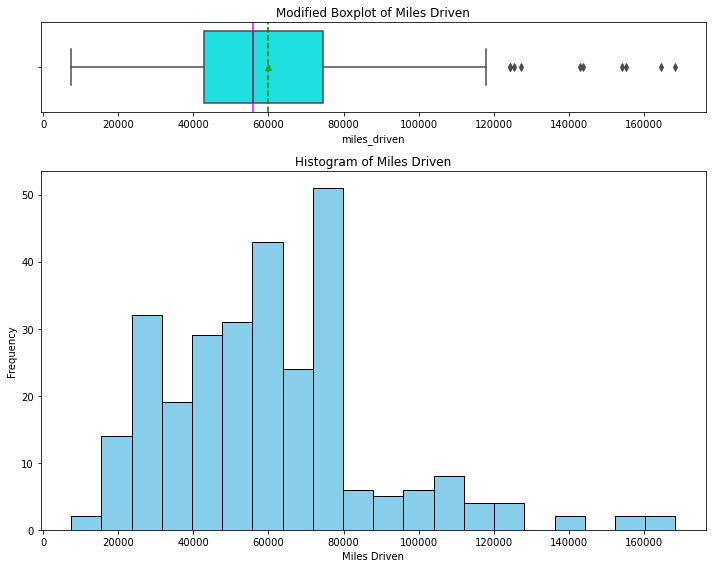

In [147]:

# Create a figure and a grid of subplots with 2 rows and 1 column
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [0.2, 0.8]})

# Create a modified boxplot for 'miles_driven'
sns.boxplot(x=df['miles_driven'], ax=ax_box, showmeans=True, color='cyan')
ax_box.set_title('Modified Boxplot of Miles Driven')
ax_box.grid(False)  # Remove grid lines

# Add mean and median lines to the boxplot
ax_box.axvline(np.mean(df['miles_driven']), color='green', linestyle='--')
ax_box.axvline(np.median(df['miles_driven']), color='magenta', linestyle='-')

# Create a histogram for 'miles_driven'
ax_hist.hist(df['miles_driven'], bins=20, color='skyblue', edgecolor='black')
ax_hist.set_title('Histogram of Miles Driven')
ax_hist.set_xlabel('Miles Driven')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(False)  # Remove grid lines

# Adjust the layout of subplots for better spacing
plt.tight_layout()

# Show the subplots
plt.show()


EXPLAIN THIS
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

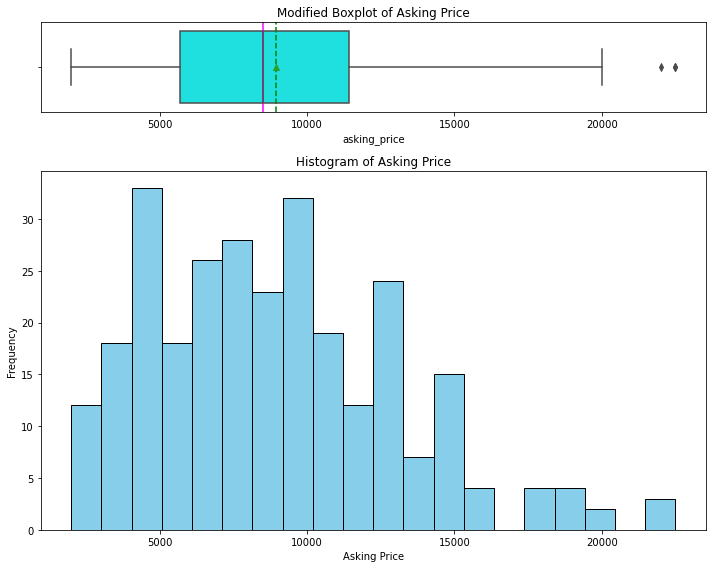

In [148]:
# Create a figure and a grid of subplots with 2 rows and 1 column
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [0.2, 0.8]})

# Create a modified boxplot for 'asking_price'
sns.boxplot(x=df['asking_price'], ax=ax_box, showmeans=True, color='cyan')
ax_box.set_title('Modified Boxplot of Asking Price')
ax_box.grid(False)  # Remove grid lines

# Add mean and median lines to the boxplot
ax_box.axvline(np.mean(df['asking_price']), color='green', linestyle='--')
ax_box.axvline(np.median(df['asking_price']), color='magenta', linestyle='-')

# Create a histogram for 'asking_price'
ax_hist.hist(df['asking_price'], bins=20, color='skyblue', edgecolor='black')
ax_hist.set_title('Histogram of Asking Price')
ax_hist.set_xlabel('Asking Price')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(False)  # Remove grid lines

# Adjust the layout of subplots for better spacing
plt.tight_layout()

# Show the subplots
plt.show()


The asking price histogram is slightly right skewed, with two high-frequency bins just before 5000 and 10000. There is a gap around 15250 and around 20000. <br>
EXPLAIN MORE?
<br>
<br>
<br>
<br>
<br>
<br>
<br>


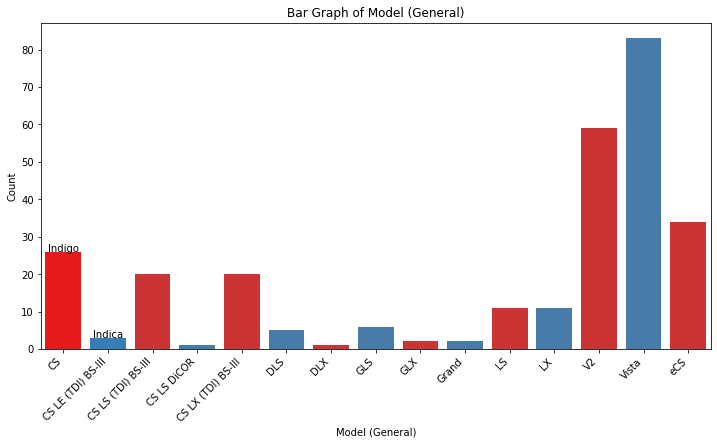

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each unique value in the 'model_gen' column
model_gen_counts = df['model_gen'].value_counts()

# Create a color map for 'model' field
colors = sns.color_palette("Set1", n_colors=len(df['model'].unique()))

# Create a bar graph with colors based on 'model'
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=model_gen_counts.index, y=model_gen_counts.values, palette=colors)
plt.title('Bar Graph of Model (General)')
plt.xlabel('Model (General)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Add a legend for 'model' values
for patch, label in zip(ax.patches, df['model'].unique()):
    color = colors[df['model'].unique().tolist().index(label)]
    patch.set_facecolor(color)
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), label, ha='center', color='black')

plt.show()


INCLUDE EXPLANATION
<br>
<br>
<br>
<br>
<br>
<br>
<br>



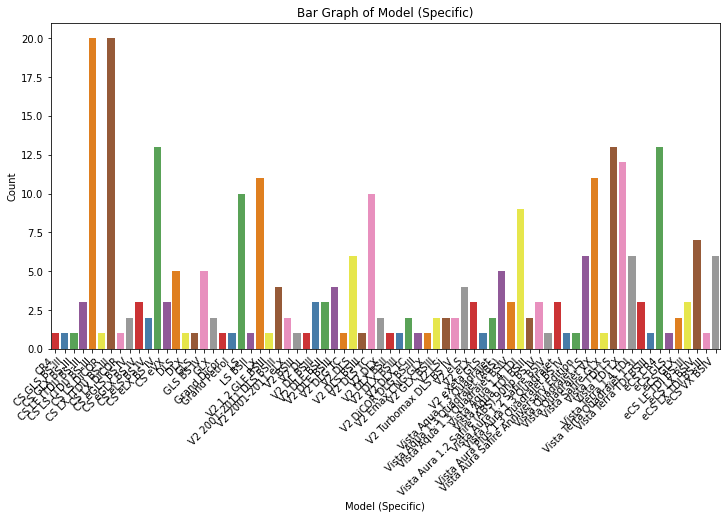

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each unique value in the 'model_spec' column
model_spec_counts = df['model_spec'].value_counts()

# Create a bar graph for 'model_spec'
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=model_spec_counts.index, y=model_spec_counts.values, palette="Set1")
plt.title('Bar Graph of Model (Specific)')
plt.xlabel('Model (Specific)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()

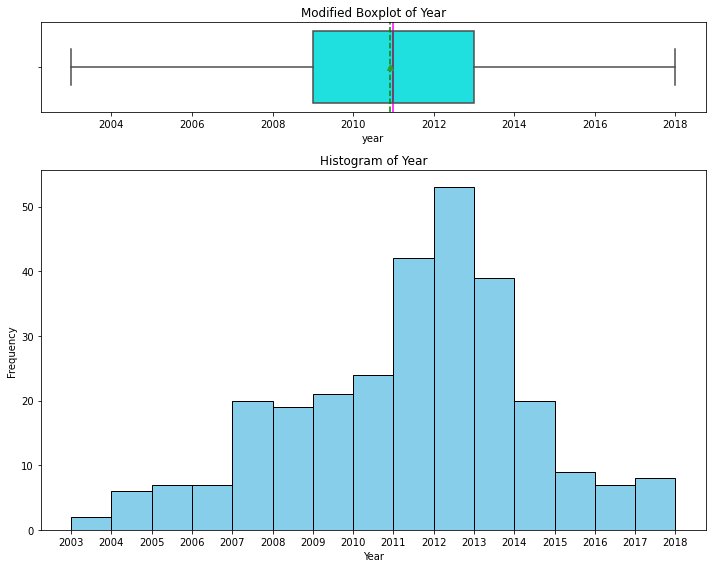

In [151]:
# Create a figure and a grid of subplots with 2 rows and 1 column
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [0.2, 0.8]})

# Create a modified boxplot for 'year'
sns.boxplot(x=df['year'], ax=ax_box, showmeans=True, color='cyan')
ax_box.set_title('Modified Boxplot of Year')
ax_box.grid(False)  # Remove grid lines

# Add mean and median lines to the boxplot
ax_box.axvline(np.mean(df['year']), color='green', linestyle='--')
ax_box.axvline(np.median(df['year']), color='magenta', linestyle='-')

# Create a histogram for 'year' with specified bins to align with bars
bins = range(int(min(df['year'])), int(max(df['year'])) + 1)
ax_hist.hist(df['year'], bins=bins, color='skyblue', edgecolor='black')
ax_hist.set_title('Histogram of Year')
ax_hist.set_xlabel('Year')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(False)  # Remove grid lines

# Set the x-axis ticks to align with bars
ax_hist.set_xticks(bins)

# Adjust the layout of subplots for better spacing
plt.tight_layout()

# Show the subplots
plt.show()


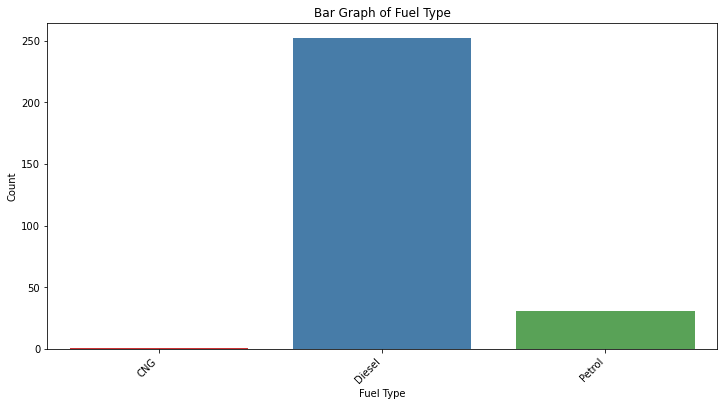

In [152]:
# Create a bar graph for 'fuel'
fuel_counts = df['fuel'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=fuel_counts.index, y=fuel_counts.values, palette="Set1")
plt.title('Bar Graph of Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

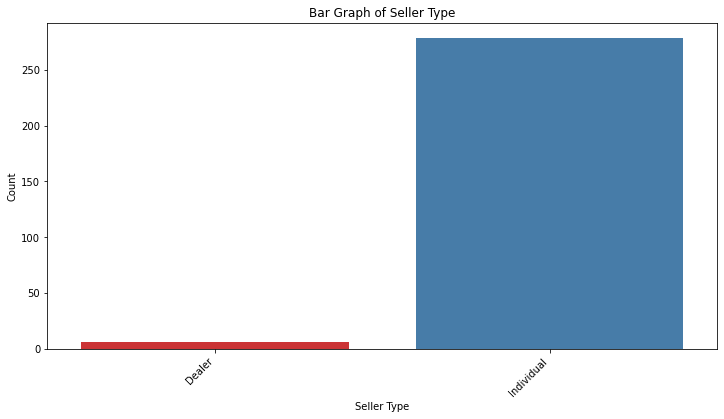

In [153]:
# Create a bar graph for 'seller_type'
seller_type_counts = df['seller_type'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=seller_type_counts.index, y=seller_type_counts.values, palette="Set1")
plt.title('Bar Graph of Seller Type')
plt.xlabel('Seller Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

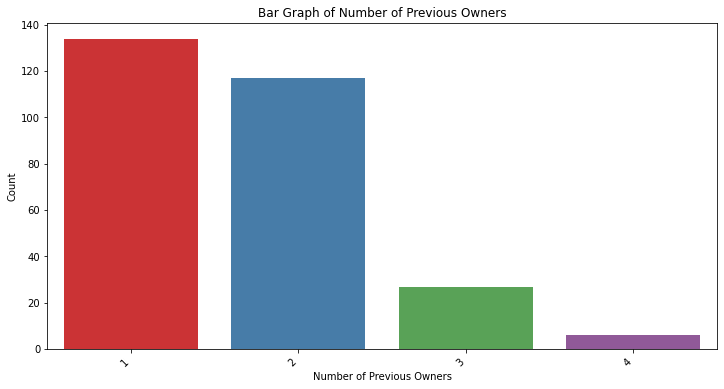

In [154]:
# Create a bar graph for 'num_previous_owners'
num_previous_owners_counts = df['num_previous_owners'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=num_previous_owners_counts.index, y=num_previous_owners_counts.values, palette="Set1")
plt.title('Bar Graph of Number of Previous Owners')
plt.xlabel('Number of Previous Owners')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

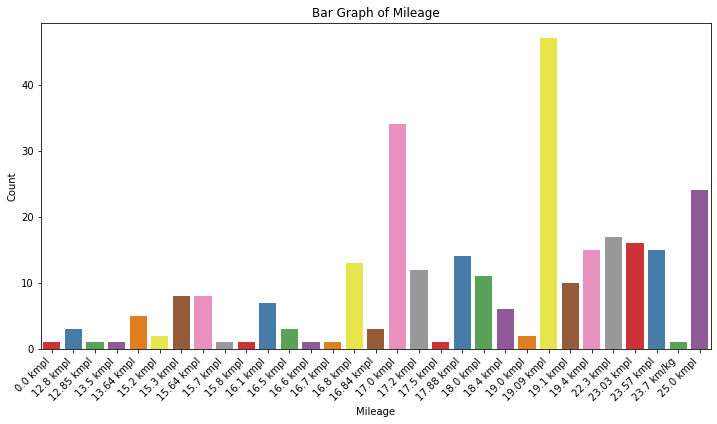

In [155]:
# Create a bar graph for 'mileage'
mileage_counts = df['mileage'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=mileage_counts.index, y=mileage_counts.values, palette="Set1")
plt.title('Bar Graph of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

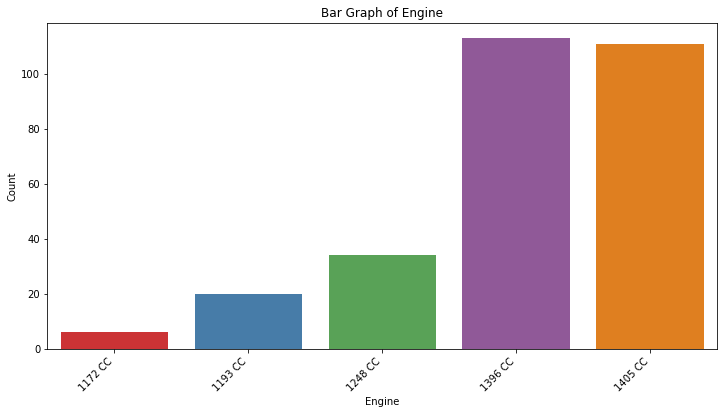

In [156]:
# Create a bar graph for 'engine'
engine_counts = df['engine'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=engine_counts.index, y=engine_counts.values, palette="Set1")
plt.title('Bar Graph of Engine')
plt.xlabel('Engine')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Step 13: Outlier and Skewness Treatment

Outliers, specifically those observed in the modified boxplots, seller type, and fuel type visualizations were kept in with the data. One reason for this was the already limited number of observations.

# Step 14: Continuation of EDA

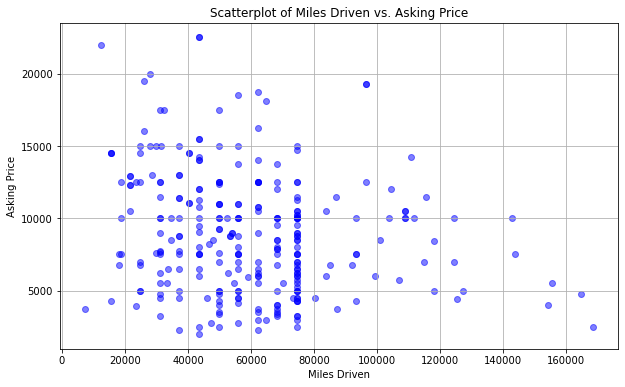

In [157]:
# Create a scatterplot of 'miles driven' vs. 'asking price'
plt.figure(figsize=(10, 6))
plt.scatter(df['miles_driven'], df['asking_price'], alpha=0.5, color='b', marker='o')
plt.title('Scatterplot of Miles Driven vs. Asking Price')
plt.xlabel('Miles Driven')
plt.ylabel('Asking Price')
plt.grid(True)

# Show the scatterplot
plt.show()


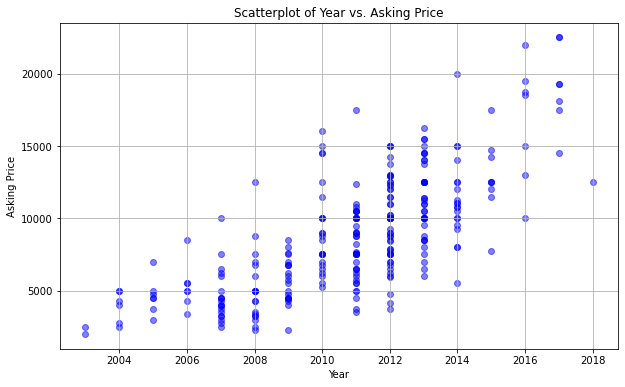

In [158]:
# Create a scatterplot of 'year' vs. 'asking price'
plt.figure(figsize=(10, 6))
plt.scatter(df['year'], df['asking_price'], alpha=0.5, color='b', marker='o')
plt.title('Scatterplot of Year vs. Asking Price')
plt.xlabel('Year')
plt.ylabel('Asking Price')
plt.grid(True)

# Show the scatterplot
plt.show()


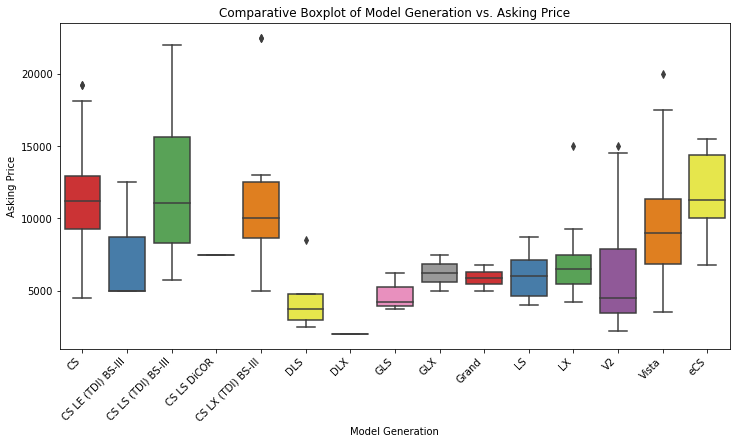

In [159]:
# Create a comparative boxplot of 'model_gen' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='model_gen', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Model Generation vs. Asking Price')
plt.xlabel('Model Generation')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


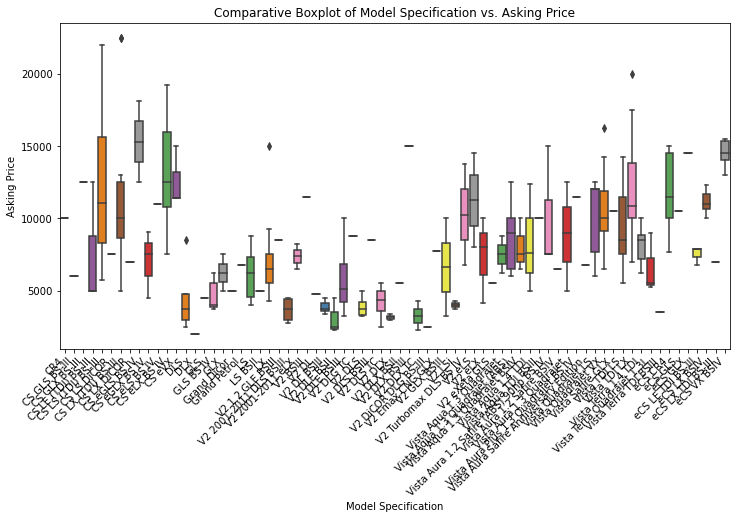

In [160]:
# Create a comparative boxplot of 'model_spec' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='model_spec', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Model Specification vs. Asking Price')
plt.xlabel('Model Specification')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


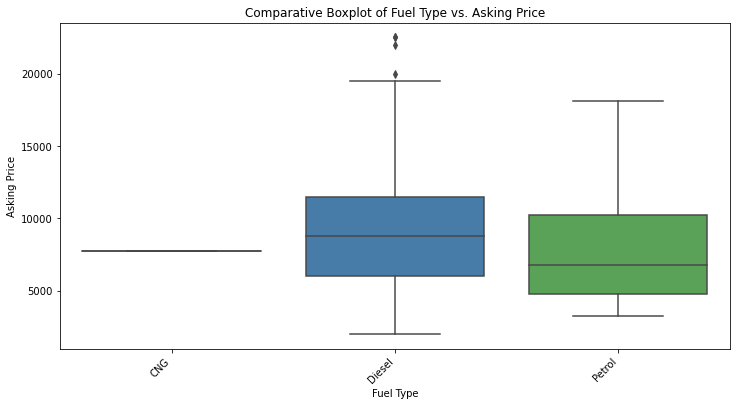

In [161]:
# Create a comparative boxplot of 'fuel_type' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='fuel', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Fuel Type vs. Asking Price')
plt.xlabel('Fuel Type')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


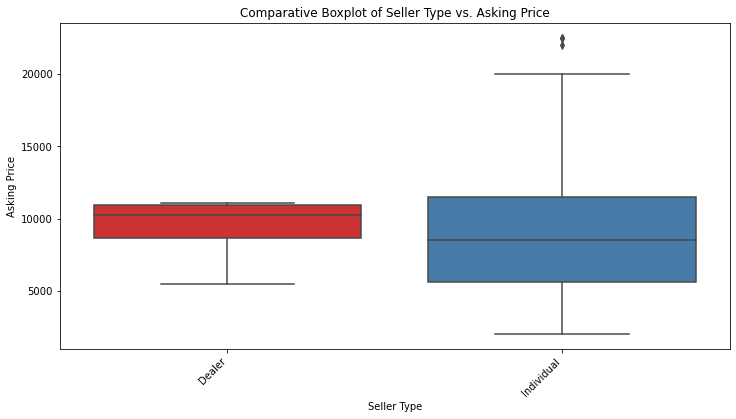

In [162]:
# Create a comparative boxplot of 'seller_type' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='seller_type', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Seller Type vs. Asking Price')
plt.xlabel('Seller Type')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


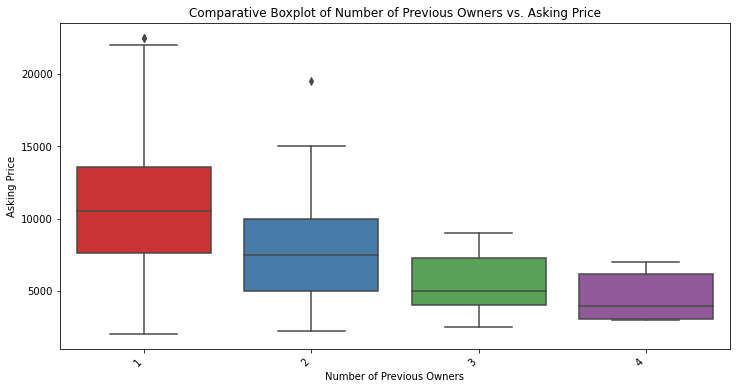

In [163]:
# Create a comparative boxplot of 'num_previous_owners' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='num_previous_owners', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Number of Previous Owners vs. Asking Price')
plt.xlabel('Number of Previous Owners')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


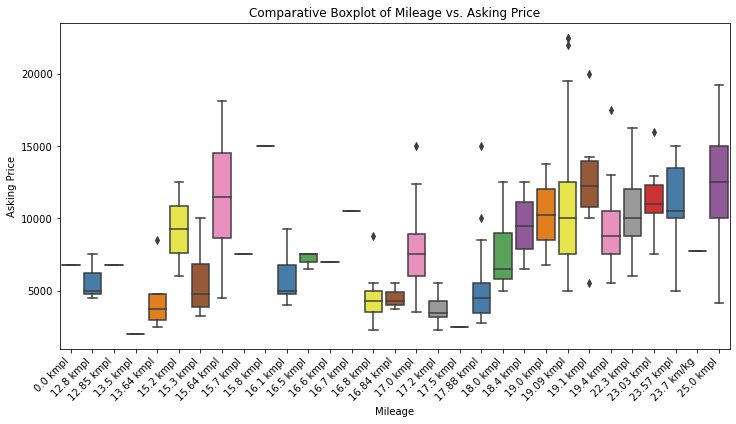

In [164]:
# Create a comparative boxplot of 'mileage' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='mileage', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Mileage vs. Asking Price')
plt.xlabel('Mileage')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()

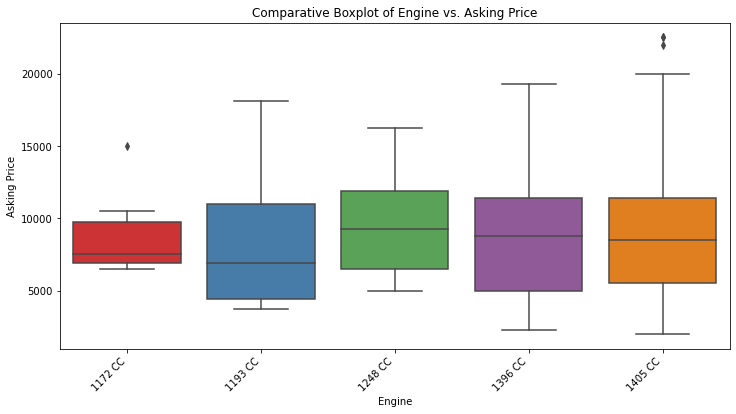

In [165]:
# Create a comparative boxplot of 'engine' vs. 'asking price'
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='engine', y='asking_price', palette="Set1")
plt.title('Comparative Boxplot of Engine vs. Asking Price')
plt.xlabel('Engine')
plt.ylabel('Asking Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()


# Step 15: Correlation Heatmap

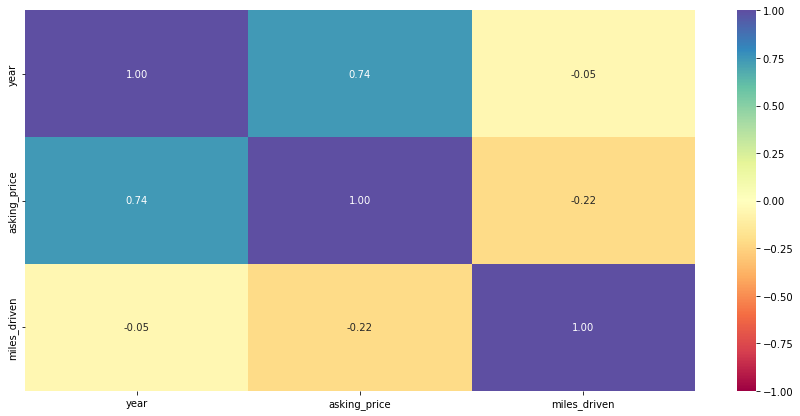

In [166]:
list_of_numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(15, 7))
sns.heatmap(
 df[list_of_numeric_columns].corr(), annot=True,
 vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

# Step 16: Interpretation of Heatmap

ADD EXPLANATION OF HEATMAP!!!!! <BR>
ADD EXPLANATION OF HEATMAP!!!!! <BR>
    ADD EXPLANATION OF HEATMAP!!!!! <BR>
    ADD EXPLANATION OF HEATMAP!!!!! <BR>
    ADD EXPLANATION OF HEATMAP!!!!! <BR>
    ADD EXPLANATION OF HEATMAP!!!!! <BR>
    ADD EXPLANATION OF HEATMAP!!!!! <BR>

# Step 17: Pruning of Explanatory Variables

In [167]:

X = X.drop(['model', 'model_spec','model_gen','fuel', 'seller_type', 'num_previous_owners', 'mileage', 'engine'], axis = 1)
X

,year,miles_driven,model_Indigo,model_gen_CS LE (TDI) BS-III,model_gen_CS LS (TDI) BS-III,model_gen_CS LS DiCOR,model_gen_CS LX (TDI) BS-III,model_gen_DLS,model_gen_DLX,model_gen_GLS,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
0,2011,52381.22727,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,2011,43484.84848,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,2011,43484.84848,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,2011,31060.60606,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,2011,108712.12120,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2011,49696.96970,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
280,2010,74545.45455,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
281,2010,62121.21212,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
282,2011,54045.45455,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Step 18: Train/Test Split

In [168]:
# Split the data into training and test data using a 75-25 split. This was chosen over a 70-30 split since the amount of data is already limited compared to the ideal amount of 300 observations
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=2112)

### Extra Credit: Confirming all columns in X have some variance

In [169]:
# Initialize a flag to check for differences of 0
has_difference_zero = False

# Loop through each column
for column in X.columns:
    # Compute the minimum and maximum values for the column
    column_min = X[column].min()
    column_max = X[column].max()

    # Check if the difference is zero
    if column_min == column_max:
        has_difference_zero = True
        print(f"Error: Column '{column}' has a difference of 0 (min = max)")

# Check if any differences of 0 were found
if has_difference_zero:
    print("Error: At least one column has a difference of 0.")
else:
    print("OK: No differences of 0 found in any column.")


OK: No differences of 0 found in any column.


In [170]:
# Add constant column to both training and test dataframes
Xtrain = sm.add_constant(Xtrain)
Xtest = sm.add_constant(Xtest)

# Step 19: Preliminary OLS Model

In [171]:
# Build OLS model and display statistical summary
model0 = sm.OLS(ytrain,Xtrain).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     7.623
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           6.00e-23
Time:                        09:28:49   Log-Likelihood:                -1766.1
No. Observations:                 198   AIC:                             3678.
Df Residuals:                     125   BIC:                             3918.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

strong multicollinearity problems or that the design matrix is singular.


### 11 p-values > 0.05

# Step 20: Significance Analysis and Revised OLS Models

## Attempt 1

In [172]:
# Try dropping model_spec_V2 Emax CNG GLX
columns_to_drop = ['model_spec_V2 Emax CNG GLX']
Xtrain1 = Xtrain.drop(columns_to_drop, axis=1)

In [173]:
# Build OLS model and display statistical summary
model1 = sm.OLS(ytrain,Xtrain1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     7.623
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           6.00e-23
Time:                        09:28:50   Log-Likelihood:                -1766.1
No. Observations:                 198   AIC:                             3678.
Df Residuals:                     125   BIC:                             3918.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 11 p-values > 0.05 after dropping only mileage_16.5 kmpl; adjusted r^2 = 0.708

## Attempt 2

In [174]:
# Try dropping seller_type_Individual
columns_to_drop = ['seller_type_Individual']
Xtrain2 = Xtrain1.drop(columns_to_drop, axis=1)

In [175]:
# Build OLS model and display statistical summary
model2 = sm.OLS(ytrain,Xtrain2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     7.789
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           2.17e-23
Time:                        09:28:50   Log-Likelihood:                -1766.1
No. Observations:                 198   AIC:                             3676.
Df Residuals:                     126   BIC:                             3913.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 12 p-values > 0.05 after also dropping mileage_12.85 kmpl; adjusted r^2 = 0.693

## Attempt 3

In [176]:
# Try dropping model_spec_V2 DLX BSII
columns_to_drop = ['model_spec_V2 DLX BSII']
Xtrain3 = Xtrain2.drop(columns_to_drop, axis=1)

In [177]:
# Build OLS model and display statistical summary
model3 = sm.OLS(ytrain,Xtrain3).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     7.789
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           2.17e-23
Time:                        09:28:50   Log-Likelihood:                -1766.1
No. Observations:                 198   AIC:                             3676.
Df Residuals:                     126   BIC:                             3913.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 12 p-values > 0.05 after also dropping mileage_15.3 kmpl; higher adjusted r^2 now of 0.695

## Attempt 4

In [178]:
# Try dropping mileage_12.8 kmpl
columns_to_drop = ['mileage_12.8 kmpl']
Xtrain4 = Xtrain3.drop(columns_to_drop, axis=1)

In [179]:
# Build OLS model and display statistical summary
model4 = sm.OLS(ytrain,Xtrain4).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     7.789
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           2.17e-23
Time:                        09:28:50   Log-Likelihood:                -1766.1
No. Observations:                 198   AIC:                             3676.
Df Residuals:                     126   BIC:                             3913.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 10 p-values > 0.05 after also dropping seller_type_Individual; higher adjusted r^2 value of 0.696

## Attempt 5

In [180]:
# Try dropping num_previous_owners_4 
columns_to_drop = ['num_previous_owners_4']
Xtrain5 = Xtrain4.drop(columns_to_drop, axis=1)

In [181]:
# Build OLS model and display statistical summary
model5 = sm.OLS(ytrain,Xtrain5).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     7.956
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           7.94e-24
Time:                        09:28:50   Log-Likelihood:                -1766.2
No. Observations:                 198   AIC:                             3674.
Df Residuals:                     127   BIC:                             3908.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 8 p-values > 0.05 after also dropping mileage_15.2 kmpl ; higher adjusted r^2 value of 0.697

## Attempt 6

In [182]:
# Try dropping model_spec_V2 DLS BSIII
columns_to_drop = ['model_spec_V2 DLS BSIII']
Xtrain6 = Xtrain5.drop(columns_to_drop, axis=1)

In [183]:
# Build OLS model and display statistical summary
model6 = sm.OLS(ytrain,Xtrain6).fit()
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     7.956
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           7.94e-24
Time:                        09:28:50   Log-Likelihood:                -1766.2
No. Observations:                 198   AIC:                             3674.
Df Residuals:                     127   BIC:                             3908.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 6 p-values > 0.05 after also dropping mileage_15.2 kmpl ; higher adjusted r^2 value of 0.698

## Attempt 7

In [184]:
# Try dropping model_spec_Vista Aura 1.2 Safire BSIV
columns_to_drop = ['model_spec_Vista Aura 1.2 Safire BSIV']
Xtrain7 = Xtrain6.drop(columns_to_drop, axis=1)

In [185]:
# Build OLS model and display statistical summary
model7 = sm.OLS(ytrain,Xtrain7).fit()
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     7.956
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           7.94e-24
Time:                        09:28:51   Log-Likelihood:                -1766.2
No. Observations:                 198   AIC:                             3674.
Df Residuals:                     127   BIC:                             3908.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 4 p-values > 0.05 after also dropping model_gen_CS LE (TDI) BS-III ; lower adjusted r^2 value of 0.697

## Attempt 8

In [186]:
# Try dropping num_previous_owners_3
columns_to_drop = ['num_previous_owners_3']
Xtrain8 = Xtrain7.drop(columns_to_drop, axis=1)

In [187]:
# Build OLS model and display statistical summary
model8 = sm.OLS(ytrain,Xtrain8).fit()
print(model8.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     8.078
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           3.80e-24
Time:                        09:28:51   Log-Likelihood:                -1766.7
No. Observations:                 198   AIC:                             3673.
Df Residuals:                     128   BIC:                             3904.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 3 p-values > 0.05 after also dropping model_gen_CS LE (TDI) BS-III ; lower adjusted r^2 value of 0.696

## Attempt 9

In [188]:
# Try dropping model_spec_eCS LE TDI BS-III
columns_to_drop = ['model_spec_eCS LE TDI BS-III']
Xtrain9 = Xtrain8.drop(columns_to_drop, axis=1)

In [189]:
# Build OLS model and display statistical summary
model9 = sm.OLS(ytrain,Xtrain9).fit()
print(model9.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     8.078
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           3.80e-24
Time:                        09:28:51   Log-Likelihood:                -1766.7
No. Observations:                 198   AIC:                             3673.
Df Residuals:                     128   BIC:                             3904.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 2 p-values > 0.05 after also dropping model_gen_CS LE (TDI) BS-III ; lower adjusted r^2 value of 0.693

## Attempt 10

In [190]:
# Try dropping model_spec_eCS LX TDI BS-III
columns_to_drop = ['model_spec_eCS LX TDI BS-III']
Xtrain10 = Xtrain9.drop(columns_to_drop, axis=1)

In [191]:
# Build OLS model and display statistical summary
model10 = sm.OLS(ytrain,Xtrain10).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     8.209
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           1.76e-24
Time:                        09:28:51   Log-Likelihood:                -1767.2
No. Observations:                 198   AIC:                             3672.
Df Residuals:                     129   BIC:                             3899.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 2 p-values > 0.05 after also dropping model_gen_CS LE (TDI) BS-III ; lower adjusted r^2 value of 0.692

## Attempt 11

In [192]:
# Try dropping model_spec_V2 BSIII
columns_to_drop = ['model_spec_V2 BSIII']
Xtrain11 = Xtrain10.drop(columns_to_drop, axis=1)

In [193]:
# Build OLS model and display statistical summary
model11 = sm.OLS(ytrain,Xtrain11).fit()
print(model11.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     8.209
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           1.76e-24
Time:                        09:28:51   Log-Likelihood:                -1767.2
No. Observations:                 198   AIC:                             3672.
Df Residuals:                     129   BIC:                             3899.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 3 p-values > 0.05 after also dropping model_gen_CS LX (TDI) BS-III

## Attempt 12

In [194]:
# Try dropping model_spec_V2 DLX BSIII 
columns_to_drop = ['model_spec_V2 DLX BSIII']
Xtrain12 = Xtrain11.drop(columns_to_drop, axis=1)

In [195]:
# Build OLS model and display statistical summary
model12 = sm.OLS(ytrain,Xtrain12).fit()
print(model12.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     8.209
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           1.76e-24
Time:                        09:28:51   Log-Likelihood:                -1767.2
No. Observations:                 198   AIC:                             3672.
Df Residuals:                     129   BIC:                             3899.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 2 p-values > 0.05 after also dropping model_gen_eCS; lower adjusted r^2 of 0.690

## Attempt 13

In [196]:
# Try dropping mileage_16.84 kmpl
columns_to_drop = ['model_spec_V2 DL', 'model_spec_V2 DLE BSIII', 'model_spec_V2 DLE BSIII', 'model_spec_V2 2001-2011 DLS BSIII']
Xtrain13 = Xtrain12.drop(columns_to_drop, axis=1)

In [197]:
# Build OLS model and display statistical summary
model13 = sm.OLS(ytrain,Xtrain13).fit()
print(model13.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     8.754
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           8.19e-26
Time:                        09:28:51   Log-Likelihood:                -1767.5
No. Observations:                 198   AIC:                             3667.
Df Residuals:                     132   BIC:                             3884.
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 1 p-value > 0.05 after also dropping mileage_16.84 kmpl; lower adjusted r^2 of 0.687

## Attempt 14

In [198]:
# Try dropping 'model_spec_V2 DL BSIII'
columns_to_drop = ['model_spec_V2 DL BSIII']
Xtrain14 = Xtrain13.drop(columns_to_drop, axis=1)

In [199]:
# Build OLS model and display statistical summary
model14 = sm.OLS(ytrain,Xtrain14).fit()
print(model14.summary())

                            OLS Regression Results                            
Dep. Variable:           asking_price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     8.943
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           2.93e-26
Time:                        09:28:51   Log-Likelihood:                -1767.7
No. Observations:                 198   AIC:                             3665.
Df Residuals:                     133   BIC:                             3879.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 0 p-values > 0.05 after also dropping mileage_15.64 kmpl; higher adjusted r^2 of 0.688

# Step 21: Performance Scoring of Model on Training Data

INSERT COMMENTS ON MODEL'S R^2 AND ADJUSTED R^2

In [200]:
train_scores = regression_performance(model14, Xtrain14, ytrain)
train_scores

,MSE,MAE,MAPE
0,3.326452e+06,1295.511435,16.176033


# Step 22: Performance Scoring of Model on Test Data

In [201]:
Xtrain14

,const,year,miles_driven,model_Indigo,model_gen_CS LE (TDI) BS-III,model_gen_CS LS (TDI) BS-III,model_gen_CS LS DiCOR,model_gen_CS LX (TDI) BS-III,model_gen_DLS,model_gen_DLX,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
51,1.0,2013,49696.96970,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
247,1.0,2012,24848.48485,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
110,1.0,2005,45969.69697,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
187,1.0,2016,68333.33333,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
204,1.0,2012,49696.96970,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,1.0,2010,86969.69697,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11,1.0,2013,15530.30303,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
57,1.0,2015,74545.45455,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
166,1.0,2008,68333.33333,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [202]:
Xtest

,const,year,miles_driven,model_Indigo,model_gen_CS LE (TDI) BS-III,model_gen_CS LS (TDI) BS-III,model_gen_CS LS DiCOR,model_gen_CS LX (TDI) BS-III,model_gen_DLS,model_gen_DLX,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
127,1.0,2011,53237.87879,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
248,1.0,2014,21742.42424,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,1.0,2014,40378.78788,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
158,1.0,2007,31060.60606,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
34,1.0,2012,74545.45455,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1.0,2012,24848.48485,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
270,1.0,2013,43484.84848,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
138,1.0,2010,74545.45455,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
169,1.0,2013,74545.45455,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [203]:
columns_to_drop = [
   'model_spec_V2 Emax CNG GLX',
'seller_type_Individual',
'model_spec_V2 DLX BSII',
'mileage_12.8 kmpl',
'num_previous_owners_4',
'model_spec_V2 DLS BSIII',
'model_spec_Vista Aura 1.2 Safire BSIV',
'num_previous_owners_3',
'model_spec_eCS LE TDI BS-III',
'model_spec_eCS LX TDI BS-III',
'model_spec_V2 BSIII',
'model_spec_V2 DLX BSIII',
'model_spec_V2 DL BSIII',
'model_spec_V2 DL',
'model_spec_V2 DLE BSIII',
'model_spec_V2 DLE BSIII',
'model_spec_V2 2001-2011 DLS BSIII'
]

Xtest = Xtest.drop(columns_to_drop, axis=1)
Xtest

,const,year,miles_driven,model_Indigo,model_gen_CS LE (TDI) BS-III,model_gen_CS LS (TDI) BS-III,model_gen_CS LS DiCOR,model_gen_CS LX (TDI) BS-III,model_gen_DLS,model_gen_DLX,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
127,1.0,2011,53237.87879,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
248,1.0,2014,21742.42424,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,1.0,2014,40378.78788,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
158,1.0,2007,31060.60606,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
34,1.0,2012,74545.45455,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1.0,2012,24848.48485,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
270,1.0,2013,43484.84848,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
138,1.0,2010,74545.45455,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
169,1.0,2013,74545.45455,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [204]:
test_scores = regression_performance(model14, Xtest, ytest)
test_scores

,MSE,MAE,MAPE
0,3.216443e+09,13670.931628,164.697558
